# **Deep Learning Homework 1**







In [1]:
#load library
import torch
from keras.datasets import mnist
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist




#Part 1: Forward Propagation 



In [2]:
def initialize_parameters(layer_dims):

    '''
    initialize the W and b parameters for each layer.

    input
    ------
    layer_dims-an array of the dimensions of each layer in the network (layer 0 is the size of the flattened input, layer L is the output softmax)
    
    output
    ------
    parameters- a dictionary containing the initialized W and b parameters of each layer (W1...WL, b1...bL).
    '''
    np.random.seed(10)               
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/layer_dims[l]
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters


def linear_forward(A, W, b):
    '''
    Implement the linear part of a layer's forward propagation.
    
    input
    -----
    A – the activations of the previous layer
    W – the weight matrix of the current layer (of shape [size of current layer, size of previous layer])
    B – the bias vector of the current layer (of shape [size of current layer, 1])
    Output
    ------
    Z – the linear component of the activation function (i.e., the value before applying the non-linear function)
    linear_cache – a dictionary containing A, W, b (stored for making the backpropagation easier to compute)
    '''
    Z = np.dot(W, A) + b # Z=WXA+b
    return Z, {"W": W, "A": A, "b": b}


def softmax(Z):
    '''
    softmax function implementation

    Input
    -----
    Z – the linear component of the activation function

    Output
    ------
    A – the activations of the layer
    activation_cache – returns Z, which will be useful for the backpropagation
    '''
    A = np.exp(Z) / sum(np.exp(Z))

    return A, Z


def relu(Z):
    '''
    relu function implementation

    Input
    -----
    Z – the linear component of the activation function
    Output
    ------
    A – the activations of the layer
    activation_cache – returns Z, which will be useful for the backpropagation
    '''
    A = np.maximum(0, Z)
    return A, Z


def linear_activation_forward(A_prev, W, B, activation):
    '''
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Input
    -----
    A_prev – activations of the previous layer
    W – the weights matrix of the current layer
    B – the bias vector of the current layer
    Activation – the activation function to be used (a string, either “softmax” or “relu”)
    
    Output
    ------
    A – the activations of the current layer
    cache – a joint dictionary containing both linear_cache and activation_cache
    '''
    Z, linear_cache = linear_forward(A_prev, W, B)
    if activation == 'relu':
        A, activation_cache = relu(Z)
    else:
        A, activation_cache = softmax(Z)
    return A, (linear_cache, activation_cache)


def L_model_forward(X, parameters, use_batchnorm):
    '''
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX
    
    Input
    -----
    X – the data, numpy array of shape (input size, number of examples)
    parameters – the initialized W and b parameters of each layer
    use_batchnorm - a boolean flag used to determine whether to apply batchnorm after the activation (note that this option needs to be set to “false” in Section 3 and “true” in Section 4).
    Output
    ------
    AL – the last post-activation value
    caches – a list of all the cache objects generated by the linear_forward function
    '''
    caches = []
    num_layers = len(parameters) // 2
    A_prev = X
    for l in range(0, num_layers - 1):
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l + 1)], parameters["b" + str(l + 1)], 'relu')
        caches.append(cache)
        if use_batchnorm:
            A = apply_batchnorm(A)
        A_prev = A

    # The last layer -> apply softmax
    AL, cache = linear_activation_forward(A_prev, parameters["W" + str(num_layers)],parameters["b" + str(num_layers)], "softmax")
    caches.append(cache)
    return AL, caches


def compute_cost(AL, Y, parameter, lamda):
    '''
    Input
    -----
    AL – probability vector corresponding to your label predictions, shape (num_of_classes, number of examples)
    Y – the labels vector (i.e. the ground truth)
    lamda- parameter lambda for Regularization method. 
    parameter- dictionary of parameters.parameter[w1]= weights matrix of layer 1 parameter[b1]= vector bias of layer 1
    reg- bolean, True for using L2 Regularization else False.

    Output
    ------
    cost – the cross-entropy cost
    '''

    Sum = np.sum(Y * np.log(AL + 0.001), axis=0)
    
    m = Y.shape[1]# number of examples
    cost = -1 * np.mean(Sum)
    parameter = dictionary_to_vector(parameter)
    L2_regularization_penalty= (lamda / (2 * m)) * np.sum(np.square(parameter)) # regularize on weights only 
    cost =cost+L2_regularization_penalty # the cost + Regularization value
    return cost

def dictionary_to_vector(params_dict):
    """
    Roll a dictionary into a single vector.

    Input
    -----
    params_dict-dictionary of parameters.parameter[w1]= weights matrix of layer 1,
                parameter[b1]= vector bias of layer 1.
    Output
    -------
    params_vector- array vector of all parameters concatenated.
    """
    count = 0
    for key in params_dict.keys():
        new_vector = np.reshape(params_dict[key], (-1, 1))
        if count == 0:
             params_vector= new_vector
        else:
            params_vector = np.concatenate((params_vector, new_vector))
        count += 1
    return params_vector



def apply_batchnorm(A):
    '''
    performs batchnorm on the received activation values of a given layer.
    Input:
    A - the activation values of a given layer
    output:
    NA - the normalized activation values, based on the formula learned in class
    '''
    mean_A = np.mean(A)
    std_A = np.sqrt(np.var(A) + 0.000001)
    NA = (A - mean_A) / std_A
    return NA



# Part 2: Backward Propagation

In [3]:
def Linear_backward(dZ, cache, lamda=0):

    """Implements the linear part of the backward propagation process for a single layer

    Input
    ------
    dZ – the gradient of the cost with respect to the linear output of the current layer (layer l)
    cache – tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    lamda- parameter lambda for Regularization method. 

    Output
    -------
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = cache["A"].shape[1]
    dW = (1 / m) * np.dot(dZ, (cache["A"]).T) + (lamda / m) * cache["W"]
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot((cache["W"]).T, dZ)
    return dA_prev, dW, db



def linear_activation_backward(dA, cache, activation, lamda=0):

    """Implements the backward propagation for the LINEAR->ACTIVATION layer. 
    The function first computes dZ and then applies the linear_backward function.

    Input
    ------
    dA – post activation gradient of the current layer
    cache – contains both the linear cache and the activations cache
    lamda- parameter lambda for Regularization method. 

    Output
    -------
    dA_prev – Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW – Gradient of the cost with respect to W (current layer l), same shape as W
    db – Gradient of the cost with respect to b (current layer l), same shape as b
    """

    linear_cache, activation_cache = cache
    dz = relu_backward(dA, activation_cache) if activation == "relu" else softmax_backward(dA,activation_cache)
    dA_prev, dW, db = Linear_backward(dz, linear_cache,lamda)
    return dA_prev, dW, db



def relu_backward (dA, activation_cache):
    """Implements backward propagation for a ReLU unit

    Input
    ------
    dA – the post-activation gradient
    activation_cache – contains Z (stored during the forward propagation)

    Output
    -------
    dZ – gradient of the cost with respect to Z
    """
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ
  

def softmax_backward (dA, activation_cache):
    """Implements backward propagation for a softmax unit

    Input
    ------
    dA – the post-activation gradient
    activation_cache – contains Z (stored during the forward propagation)

    Output
    -------
    dZ – gradient of the cost with respect to Z
    """  
    dZ = dA - activation_cache["Y"]
    return dZ

def L_model_backward(AL, Y, caches, lamda=0):
    """
    Implement the backward propagation process for the entire network.

    Input
    ------
    AL - the probabilities vector, the output of the forward propagation 
    (L_model_forward) Y - the true labels vector (the "ground truth" - true classifications)
    Caches - list of caches containing for each layer: a) the linear cache; b) the activation cache

    Output
    -------
    Grads - a dictionary with the gradients
                grads["dA" + str(l)] = ... 
                grads["dW" + str(l)] = ... 
                grads["db" + str(l)] = ...  
    """

    grads_dict = {}
    (linear_cache_final, Z_final) = caches[-1] 
    activation_cache_final = {"Z":Z_final, "Y":Y}
    merged_cache = (linear_cache_final, activation_cache_final)
    num_layers = len(caches)
    dA_prev, dW, db = linear_activation_backward(AL, merged_cache, 'softmax',lamda)
    grads_dict["dA" + str(num_layers)] = dA_prev
    grads_dict["dw" + str(num_layers)] = dW
    grads_dict["db" + str(num_layers)] = db

    for layer in reversed(range(num_layers-1)):
        merged_cache = caches[layer]
        dA = dA_prev
        dA_prev, dW, db = linear_activation_backward(dA, merged_cache, 'relu', lamda)
        grads_dict["dA" + str(layer+1)] = dA_prev
        grads_dict["dw" + str(layer+1)] = dW
        grads_dict["db" + str(layer+1)] = db

    return grads_dict



def Update_parameters(parameters, grads, learning_rate):
    '''
    Updates parameters using gradient descent

    Input
    ------
    parameters – a python dictionary containing the DNN architecture’s parameters
    grads – a python dictionary containing the gradients 
    (generated by L_model_backward) learning_rate – the learning rate used to update the parameters (the “alpha”)

    Output
    -------
    parameters – the updated values of the parameters object provided as input 
    '''
    updated_params = {}
    for l in range(1, int(len(parameters) / 2)+1):
        updated_params['W' + str(l)] = parameters['W' + str(l)] - learning_rate * grads['dw' + str(l)]
        updated_params['b' + str(l)] = parameters['b' + str(l)] - learning_rate * grads['db' + str(l)]
    return updated_params




#Part 3: Training The Model

In [6]:
import numpy as np
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations=100, batch_size=32, lamda=0, use_batchnorm=False, info=[]):
    '''
    Input
    -----
    X – the input data, a numpy array of shape (height*width , number_of_examples). 
    Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples).
    Layer_dims – a list containing the dimensions of each layer, including the input batch_size – the number of examples in a single training batch.
    learning_rate- learning_rate for Update_parameters function.
    num_iterations - number of iteration, defult-100.
    batch_size- batch size for training the model, defult=32.
    lamda- parameter lambda for Regularization method. 
    use_batchnorm- bolean, if True apply batchnorm.
    info- list for save all metrics.

    Output
    ------
    parameters – the parameters learnt by the system during the training 
                (the same parameters that were updated in the update_parameters function).
    costs – the values of the cost function(calculated by the compute_cost function). 
            One value is to be saved after each 100 training iterations (e.g. 3000 iterations -> 30 values).
    '''
    costs_train,costs_valid = [],[]

    # Divide into train (80% of train set) and validation(20% of the train set)
    train_size = int(X.shape[1] * 0.8)
    np.random.seed(10)
    ind = np.random.permutation(X.shape[1])
    ind_X = ind[:train_size]
    ind_validation = ind[train_size:]
    X_train,X_valid = X[:, ind_X],X[:, ind_validation]
    Y_train,Y_valid = Y[:, ind_X], Y[:, ind_validation] # Y is one hot vector x number of classes

    # initialize the parameters
    parameter = initialize_parameters(layers_dims)

    # step = int(X_train.shape[1] / batch_size) # amount of batches
    batch_count = 1 # count the number of training
    epoch_num=0
    for epoch in range(num_iterations):  
        for ind, i in enumerate(range(0, X_train.shape[1], batch_size)):
            end = i + min(batch_size, X_train.shape[1] - i) # Index to the end of the batch
            
            X_train_batch = X_train[:, i:end]
            Y_train_batch = Y_train[:, i:end]
            
            AL, cache = L_model_forward(X_train_batch, parameter, use_batchnorm) #run forward propagation
            grads = L_model_backward(AL, Y_train_batch, cache, lamda)#run backward propagation
            parameter = Update_parameters(parameter, grads, learning_rate) # update parameters
            epoch_num=epoch


            if batch_count % 100 == 0:
                loss_train = compute_cost(AL, Y_train_batch,parameter, lamda)
                costs_train.append(loss_train)
                AL_validation, cache_validation = L_model_forward(X_valid, parameter, use_batchnorm)
                cost_validation = compute_cost(AL_validation, Y_valid,parameter, lamda)
                costs_valid.append(cost_validation)
                print("The cost after " + str(batch_count)+ '  training steps: '+ str(round(loss_train,5)))

                # check improvement threshold
                if len(costs_valid) > 1 and np.abs(costs_valid[-2] - costs_valid[-1]) <0.0001:
                    train_accuracy = Predict(X_train, Y_train, parameter,use_batchnorm )
                    validation_accuracy = Predict(X_valid, Y_valid, parameter,use_batchnorm)
                    epoch_num=epoch
                    print("Parameter Network:"+'\n'+str(parameter))
                    print(f'Epoch Num: {round(epoch_num, 4)}')
                    print(f'Num Iteration: {round(batch_count, 4)}')
                    print(f'Costs Train: {round(costs_train[-1], 4)}')
                    print(f'Costs Validation: {round(costs_valid[-1], 4)}')
                    print(f'Train Accuracy: {round(train_accuracy, 4)}')
                    print(f'Validation Accuracy: {round(validation_accuracy, 4)}')
                    info.append([epoch_num,batch_count,train_accuracy,validation_accuracy, costs_train, costs_valid])
                    return parameter,costs_train
            batch_count += 1

    # if reached the end: calculate train & validation accuracy and finish.
    train_accuracy = Predict(X_train, Y_train, parameter,use_batchnorm)
    validation_accuracy = Predict(X_valid, Y_valid, parameter,use_batchnorm)
    print("Parameter Network:"+'\n'+str(parameter))
    print(f'Epoch Num: {round(epoch_num, 4)}')
    print(f'Num Iteration: {round(batch_count, 4)}')
    print(f'Costs Train: {round(costs_train[-1], 4)}')
    print(f'Costs Validation: {round(costs_valid[-1], 4)}')
    print(f'Train Accuracy: {round(train_accuracy, 4)}')
    print(f'Validation Accuracy: {round(validation_accuracy, 4)}')
    info.append([epoch_num,batch_count,train_accuracy,validation_accuracy, costs_train, costs_valid])
    return parameter,costs_train


def Predict(X, Y, parameters, use_batchnorm=False):
    """
    The function receives an input data and the true labels and calculates the accuracy of the trained neural network on the data.
    
    Input
    -----
    X – the input data, a numpy array of shape (height*width, number_of_examples) Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
    Parameters – a python dictionary containing the DNN architecture’s parameters
    
    Output
    accuracy – the accuracy measure of the neural net on the provided data (i.e. the percentage of the samples for which the correct label receives the hughest confidence score). Use the softmax function to normalize the output values.
    """
    # calculate activations 
    AL, cache = L_model_forward(X, parameters, use_batchnorm)
    Y_idx = np.argmax(Y, axis=0)# get max probability of Y (true)
    AL_idx = np.argmax(AL, axis=0)# get max probability of  AL (predicted)
    correct = np.sum(AL_idx == Y_idx)
    total_samples = Y.shape[1]
    # calculate accuracy
    accuracy = correct / total_samples
    return accuracy






# Part 4:

The cost after 100  training steps: 2.2893
The cost after 200  training steps: 2.28891
The cost after 300  training steps: 2.2913
The cost after 400  training steps: 2.29591
The cost after 500  training steps: 2.29311
The cost after 600  training steps: 2.28209
The cost after 700  training steps: 2.29178
The cost after 800  training steps: 2.28608
The cost after 900  training steps: 2.30032
The cost after 1000  training steps: 2.28352
The cost after 1100  training steps: 2.28734
The cost after 1200  training steps: 2.29381
The cost after 1300  training steps: 2.28818
The cost after 1400  training steps: 2.30231
The cost after 1500  training steps: 2.28465
The cost after 1600  training steps: 2.28081
The cost after 1700  training steps: 2.28628
The cost after 1800  training steps: 2.28683
The cost after 1900  training steps: 2.29365
The cost after 2000  training steps: 2.28587
The cost after 2100  training steps: 2.26793
The cost after 2200  training steps: 2.28284
The cost after 2300  

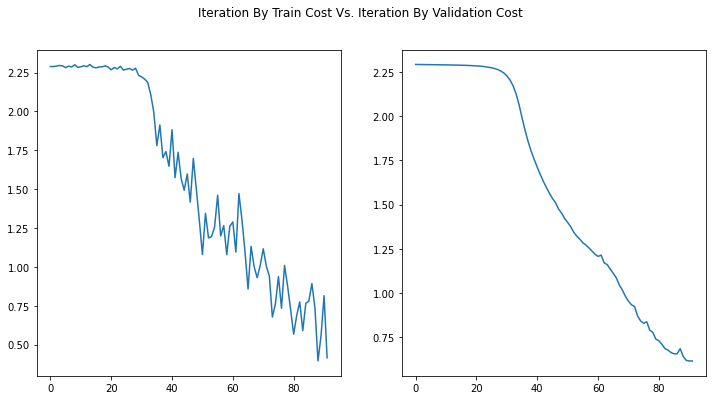

The cost after 100  training steps: 2.26817
The cost after 200  training steps: 2.25502
The cost after 300  training steps: 2.23328
The cost after 400  training steps: 2.13048
The cost after 500  training steps: 2.05928
The cost after 600  training steps: 1.99592
The cost after 700  training steps: 1.99073
The cost after 800  training steps: 1.88275
The cost after 900  training steps: 1.88368
The cost after 1000  training steps: 1.70995
The cost after 1100  training steps: 1.72069
The cost after 1200  training steps: 1.72028
The cost after 1300  training steps: 1.72314
The cost after 1400  training steps: 1.6319
The cost after 1500  training steps: 1.64554
The cost after 1600  training steps: 1.56039
The cost after 1700  training steps: 1.5841
The cost after 1800  training steps: 1.57807
The cost after 1900  training steps: 1.5988
The cost after 2000  training steps: 1.4762
The cost after 2100  training steps: 1.44923
The cost after 2200  training steps: 1.67305
The cost after 2300  tr

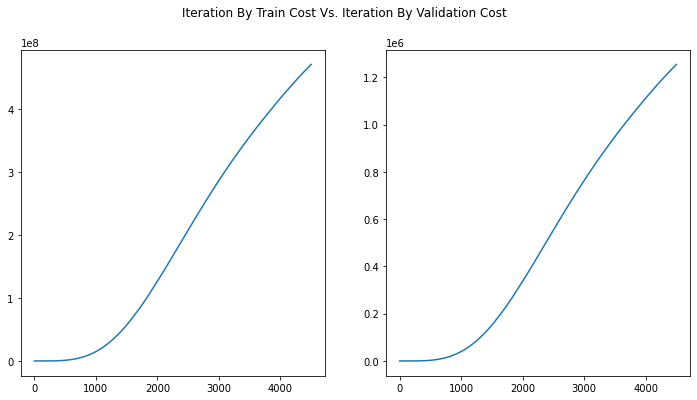

The cost after 100  training steps: 2.31638
The cost after 200  training steps: 2.31593
The cost after 300  training steps: 2.31827
The cost after 400  training steps: 2.32283
The cost after 500  training steps: 2.31997
The cost after 600  training steps: 2.30892
The cost after 700  training steps: 2.31856
The cost after 800  training steps: 2.31286
The cost after 900  training steps: 2.32698
The cost after 1000  training steps: 2.31018
The cost after 1100  training steps: 2.31392
The cost after 1200  training steps: 2.32039
The cost after 1300  training steps: 2.31473
The cost after 1400  training steps: 2.32881
The cost after 1500  training steps: 2.3112
The cost after 1600  training steps: 2.30724
The cost after 1700  training steps: 2.31286
The cost after 1800  training steps: 2.31346
The cost after 1900  training steps: 2.32051
The cost after 2000  training steps: 2.31288
The cost after 2100  training steps: 2.29555
The cost after 2200  training steps: 2.31037
The cost after 2300 

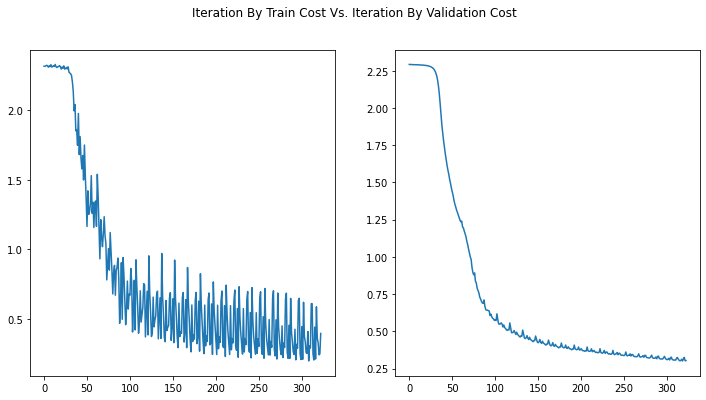

The cost after 100  training steps: 2.24106
The cost after 200  training steps: 2.22791
The cost after 300  training steps: 2.20614
The cost after 400  training steps: 2.10307
The cost after 500  training steps: 2.03157
The cost after 600  training steps: 1.96755
The cost after 700  training steps: 1.96178
The cost after 800  training steps: 1.85286
The cost after 900  training steps: 1.85341
The cost after 1000  training steps: 1.67743
The cost after 1100  training steps: 1.68857
The cost after 1200  training steps: 1.68662
The cost after 1300  training steps: 1.68963
The cost after 1400  training steps: 1.59766
The cost after 1500  training steps: 1.61124
The cost after 1600  training steps: 1.52385
The cost after 1700  training steps: 1.5463
The cost after 1800  training steps: 1.54145
The cost after 1900  training steps: 1.55913
The cost after 2000  training steps: 1.43284
The cost after 2100  training steps: 1.40538
The cost after 2200  training steps: 1.62634
The cost after 2300 

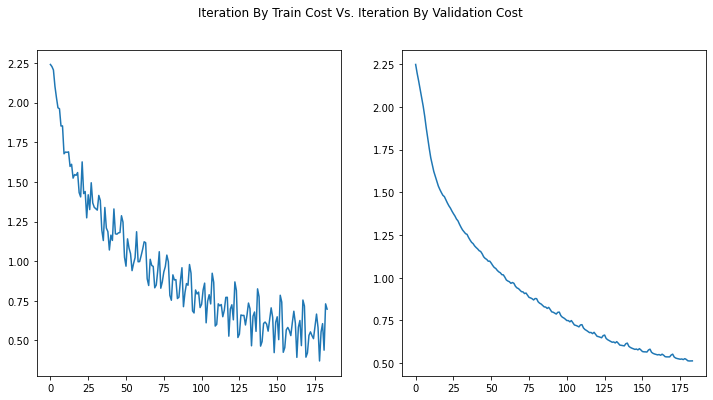

Experiment Number  Apply Batchnorm  L2 parameter  Train Accuracy  \
0                  1            False          0.00           0.809   
1                  2             True          0.04           0.939   
2                  3            False          0.04           0.927   
3                  4             True          0.00           0.868   

   Validation Accuracy  Test Accuracy  Iteration  Epoch Number  Training Time  \
0                0.805          0.809       9200             6         15.760   
1                0.932          0.934     450001           299        893.624   
2                0.909          0.917      32300            21         52.093   
3                0.862          0.867      18400            12         37.533   

   Training Final Cost  Validation Final Cost  
0         4.150000e-01                  0.617  
1         4.704672e+08            1254579.448  
2         3.960000e-01                  0.303  
3         6.970000e-01                  0.513

The weight differences between not using L2 and using L2 in the 1 layer:
[[ 0.02   0.011 -0.024 ... -0.004  0.003  0.017]
 [-0.018 -0.006  0.006 ... -0.015 -0.01   0.018]
 [-0.003 -0.003  0.018 ...  0.019 -0.007  0.01 ]
 ...
 [ 0.005  0.017 -0.006 ... -0.005 -0.01  -0.004]
 [ 0.015  0.012 -0.004 ... -0.008  0.007 -0.013]
 [-0.012 -0.007 -0.004 ... -0.007  0.001 -0.013]]
The weight differences between not using L2 and using L2 in the 2 layer:
[[-0.133  0.144  0.264 -0.093 -0.052 -0.299 -0.347 -0.152  0.14  -0.332
   0.34  -0.125  0.27   0.042  0.483 -0.178  0.009 -0.207 -0.274 -0.018]
 [-0.065 -0.014  0.102  0.006  0.017 -0.025 -0.002 -0.016  0.019  0.049
  -0.035 -0.044 -0.053 -0.045  0.009  0.066 -0.059 -0.054  0.018 -0.055]
 [ 0.054 -0.098  0.195  0.034  0.173 -0.078 -0.079 -0.162 -0.12   0.013
   0.173  0.195 -0.039  0.039  0.242 -0.026  0.126 -0.052 -0.139 -0.036]
 [ 0.026 -0.245  0.342 -0.144 -0.066  0.04  -0.197 -0.088  0.141 -0.038
  -0.277 -0.019 -0.457 -0.117  0.201  0.023  0.

In [7]:

def Model(num_iterations, batch_size, use_batchnorm, threshold, lamda, learning_rate):

    # start the clock
    info=[]
    start = datetime.datetime.now()
    # start the training
    parameter,costs_train=L_layer_model(x_train_flatten.T, y_train_encoded.T, layers_dim, learning_rate, num_iterations, batch_size, lamda,use_batchnorm,info)    
    total = (datetime.datetime.now() - start).total_seconds()
    info=info[0]
    costs_train, costs_valid=info[-2],info[-1]
    test_accuracy = Predict(x_test_flatten.T, y_test_encoded.T, parameter,use_batchnorm)
    print(f'Test Accuracy: {round(test_accuracy, 4)}')
    

    # # create plots for report

    x1= [i for i in range(len(costs_train))]
    x2= [i for i in range(len(costs_valid))]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # fig = plt.figure()

    fig.set_size_inches(12, 6)
    fig.suptitle('Iteration By Train Cost Vs. Iteration By Validation Cost')
    ax1.plot(x1, costs_train)
    ax2.plot(x2, costs_valid)
    plt.show()

    return info, total,test_accuracy, costs_valid, costs_train,parameter



def run():
    """
    A function that runs the experiments by calling run_model
    """
    #parameter
    num_iterations=300
    batch_sizes = [32,32, 32, 32]
    use_batchnorm=[False, True, False, True]
    lamda=[0,0.04,0.04,0]
    threshold=0.0001
    learning_rate=0.009
    parameter_lst=[]
    for_table={"Experiment Number":[1,2,3,4],"Apply Batchnorm":use_batchnorm,"L2 parameter":lamda,"Train Accuracy":[],"Validation Accuracy":[],"Test Accuracy":[],"Iteration":[],"Epoch Number":[],"Training Time":[],"Training Final Cost":[],"Validation Final Cost":[]}
    for i in range(4):
        x=Model(num_iterations, batch_sizes[i], use_batchnorm[i],threshold, lamda[i],learning_rate)
        for_table["Epoch Number"].append(x[0][0])
        for_table["Iteration"].append(x[0][1])
        for_table["Train Accuracy"].append(round(x[0][2],3))
        for_table["Validation Accuracy"].append(round(x[0][3],3)) 
        for_table["Training Final Cost"].append(round(x[4][-1],3)) 
        for_table["Validation Final Cost"].append(round(x[0][5][-1],3)) 
        for_table["Training Time"].append(round(x[1],3)) 
        for_table["Test Accuracy"].append(round(x[2],3)) 
        parameter_lst.append(x[5])

    df_final_2 = pd.DataFrame (for_table, columns = ["Experiment Number","Apply Batchnorm","L2 parameter","Train Accuracy","Validation Accuracy","Test Accuracy","Iteration","Epoch Number","Training Time","Training Final Cost","Validation Final Cost"])
    display(df_final_2)
    # print([np.round(parameter_lst[0]['W1']-parameter_lst[2]['W1'],3),np.round(parameter_lst[0]['W2']-parameter_lst[2]['W2'],3),np.round(parameter_lst[0]['W3']-parameter_lst[2]['W3'],3),np.round(parameter_lst[0]['W4']-parameter_lst[2]['W4'],3)])
    print("The weight differences between not using L2 and using L2 in the 1 layer:" +'\n'+ str(np.round(parameter_lst[0]['W1']-parameter_lst[2]['W1'],3)))
    print("The weight differences between not using L2 and using L2 in the 2 layer:"  +'\n'+ str(np.round(parameter_lst[0]['W2']-parameter_lst[2]['W2'],3)))
    print("The weight differences between not using L2 and using L2 in the 3 layer:" +'\n'+ str(np.round(parameter_lst[0]['W3']-parameter_lst[2]['W3'],3)))
    print("The weight differences between not using L2 and using L2 in the 4 layer:" +'\n'+ str(np.round(parameter_lst[0]['W4']-parameter_lst[2]['W4'],3)))


def one_hot_encoding(y):
    y_encoded = np.zeros((y.size, 10))
    all_lines = np.arange(y.size)
    y_encoded[all_lines, y] = 1
    return y_encoded

# Parameters
layers = 4
layers_dim = [20, 7, 5, 10]


# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize dataset by 255 (max value)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the input of train and test
x_train_flatten = x_train.reshape((x_train.shape[0], 784), order='F')
x_test_flatten = x_test.reshape((x_test.shape[0], 784), order='F')


y_train_encoded = one_hot_encoding(y_train)
y_test_encoded = one_hot_encoding(y_test)
layers_dim.insert(0, x_train_flatten.shape[1])

run()